## Exploring Ways to Predict Longevity for Defensive Players

This is a playground notebook for trying to determine the longevity for Trey Hendrickson. The best I have so far is to look at the distribution of seasons for all players who made it to age 30 in the league and then calculating the survival rate using that data. I think I need to better understand time series analysis (maybe?) and survival analysis to model this more precisely. Other data would be helpful also, like injury likelihood by position or even by player. I'm sure there is some good research out there on the likelihood of a defensive end of Trey's size and history that would provide better insights.

In [333]:
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pyplot as plt
from sklearn import linear_model
from common import ROOT_PATH
sys.path.append("../..")

from utils import get_def_player_stats, get_players_info, get_contract_data

### Get the NFLVerse Data

The best data I have to work with is the NFLVerse data so I begin by aggregating the statistics that I think will be helpful for this exercise.

In [334]:
# Offensive positions can still show up in defensive stats (QB tackling someone who intercepted their pass)
offensive_positions = [
    "LS",
    "G",
    "K",
    "WR",
    "TE",
    "RB",
    "FB",
    "P",
    "OG",
    "OT",
    "T",
    "QB",
    "OL",
    "C",
]

In [335]:
all_df = get_def_player_stats(list(range(1999, 2025)))

# Post seasons stats would skew things
all_df = all_df[(all_df["season_type"] == "REG") & (~all_df["position"].isin(offensive_positions))]

all_df = all_df.rename(columns={"week": "games"})

# Add some players specific information
players_df = get_players_info()
all_df["birth_date"] = all_df["player_id"].map(
    players_df.set_index("gsis_id")["birth_date"], na_action="ignore"
)
all_df["entry_year"] = all_df["player_id"].map(
    players_df.set_index("gsis_id")["entry_year"], na_action="ignore"
)
all_df["status"] = all_df["player_id"].map(
    players_df.set_index("gsis_id")["status"], na_action="ignore"
)
# Anyone missing a birth date probably isn't in the stats anyways but let's filter out
all_df = all_df[all_df["birth_date"].notna()]

# Calculate the estimated age for each season. Could consider doing this by week
all_df["age"] = all_df["season"] - pd.DatetimeIndex(all_df["birth_date"]).year


In [336]:
# Build a raw dataframe of all defensive players aggregated by player and season
def_df = all_df[
    [
        "player_id",
        "season",
        "games",
        "player_display_name",
        "def_tackles",
        "def_sacks",
        "def_tackles_for_loss",
        "def_qb_hits",
        "def_interceptions",
        "age",
    ]
]

def_df = def_df.groupby(["player_id", "season"]).agg(
    {
        "player_display_name": "max",
        "age": "max",
        "games": "count",
        "def_sacks": "sum",
        "def_tackles": "sum",
        "def_tackles_for_loss": "sum",
        "def_qb_hits": "sum",
        "def_interceptions": "sum",
    }
)

In [337]:
# Build a raw dataframe of retired players aggregated by player and season
retired_df = all_df[
    ~((all_df["status"] == "ACT"))
]

# Only use columns I care about
retired_df = retired_df[
    [
        "player_id",
        "season",
        "games",
        "player_display_name",
        "def_tackles",
        "def_sacks",
        "def_tackles_for_loss",
        "def_qb_hits",
        "def_interceptions",
        "age",
        "status",
        "position"
    ]
]

retired_df = retired_df.groupby(["player_id", "season"]).agg(
    {
        "player_display_name": "max",
        "age": "max",
        "games": "count",
        "def_sacks": "sum",
        "def_tackles": "sum",
        "def_tackles_for_loss": "sum",
        "def_qb_hits": "sum",
        "def_interceptions": "sum",
        "status": "max",
        "position": "max"
    }
)

## Graveyard of failed attempts to train a regresser on number of seasons after the player turns 30

Attemping any machine learning to perform a regression on defensive players is not fruitful. You can see the correlation matrix a few cells down and we just don't have a good correlation between how well a player performs and how long they will remain in the league.

By the end I find just using the survival percentage each season is the best I can do so far.

In [338]:
# Only keep players who have played whole career in the data range
supp_df = pd.read_csv(f"{ROOT_PATH}/data/players_supplemental.csv")
supp_scraped_years = pd.read_csv(f"{ROOT_PATH}/data/with_entry_year.csv")

supp_df = supp_df[supp_df["birth_date"].str.contains("/") == True]

# Players Dataset Preprocessing

# Add a new draft_year column based on supplemental data. We'll use this in addition to the provided `entry_year` to determine whether all of the player's seasons are in the dataset.
# Consistently format the birth_date column in both dataframes
supp_df["birth_date"] = pd.to_datetime(
    supp_df["birth_date"], format="%m/%d/%Y", errors="ignore"
)
players_df["birth_date"] = pd.to_datetime(
    players_df["birth_date"], format="%Y-%m-%d", errors="ignore"
)
merged_players_df = players_df.merge(
    supp_df[["first_name", "last_name", "birth_date", "draft_year"]],
    on=["first_name", "last_name", "birth_date"],
    how="outer",
)


def set_entry_year(row):
    if row["entry_year"]:
        return row["entry_year"]
    elif (
        supp_scraped_years[supp_scraped_years["player_id"] == row["gsis_id"]].count()
        > 0
    ):
        return supp_scraped_years[supp_scraped_years["player_id"] == row["gsis_id"]][
            "entry_year"
        ]
    return row["draft_year"]


# set the entry_year to the draft_year if the entry_year is null
merged_players_df["entry_year"] = merged_players_df.apply(
    set_entry_year,
    axis=1,
)

# Remove any players who have no entry_year or entered the league before 1999
merged_players_df = merged_players_df[
    (merged_players_df["entry_year"].notnull())
    & (merged_players_df["entry_year"] >= 1999)
]

# Set draft round to 0 if it is null (means undrafted)
merged_players_df["draftround"] = merged_players_df.apply(
    lambda row: (20 if pd.isnull(row["draftround"]) else row["draftround"]), axis=1
)

# Set the name to be used later
clean_players_df = merged_players_df
# Normalized Data
pivot_df = def_df.reset_index()
pivot_df = pivot_df[pivot_df["player_id"].isin(clean_players_df["gsis_id"].to_list())]
pivot_df = pivot_df.pivot(index='player_id', columns='season', values=['def_sacks', 'def_tackles', 'def_tackles_for_loss', 'def_qb_hits', 'def_interceptions', 'age']).fillna(0)
normalized_df=(pivot_df-pivot_df.min())/(pivot_df.max()-pivot_df.min())
normalized_df['age'] = pivot_df['age'].fillna(0)
unpivot_df = normalized_df.stack(level=1).fillna(0)
# Remove any rows with all zeros
unpivot_df = unpivot_df[(unpivot_df != 0).any(axis=1)]

# get all players who played over the age of 30 as a list of player_ids
older_than_30 = def_df[def_df['age'] >= 30]
older_than_30 = older_than_30.groupby("player_id").last().index.tolist()

# remove any players not in older_than_30
unpivot_df = unpivot_df[unpivot_df.index.get_level_values(0).isin(older_than_30)]

# Add a column with the max age for each player
unpivot_df = unpivot_df.reset_index()
unpivot_df['max_age'] = unpivot_df.groupby('player_id')['age'].transform('max')

# remove all rows where the age is greater than 30
unpivot_df = unpivot_df[unpivot_df['age'] <= 30]
# average the values for def_sacks, def_tackles, def_tackles_for_loss, def_qb_hits, def_interceptions
unpivot_df = unpivot_df.groupby('player_id').agg({
    'def_sacks': 'mean',
    'def_tackles': 'mean',
    'def_tackles_for_loss': 'mean',
    'def_qb_hits': 'mean',
    'def_interceptions': 'mean',
    'max_age': 'max',
})
unpivot_df.head(5)

,def_sacks,def_tackles,def_tackles_for_loss,def_qb_hits,def_interceptions,max_age
player_id,,,,,,
00-0020712,0.336723,0.368155,0.133333,0.269658,0.113333,39.0
00-0021140,0.686846,0.497741,0.247751,0.451037,0.234215,38.0
00-0021146,0.732419,0.373153,0.282960,0.481329,0.000000,37.0
00-0021684,0.055246,0.228794,0.038509,0.035474,0.000000,35.0
00-0021706,0.294393,0.226748,0.159749,0.335984,0.013889,35.0


<Axes: >

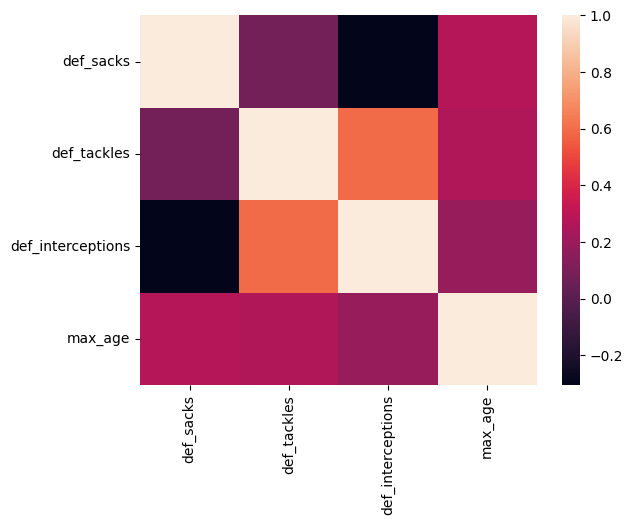

In [339]:
final_corr_df = unpivot_df.drop(columns=['def_qb_hits', 'def_tackles_for_loss'])
sns.heatmap(final_corr_df.corr())

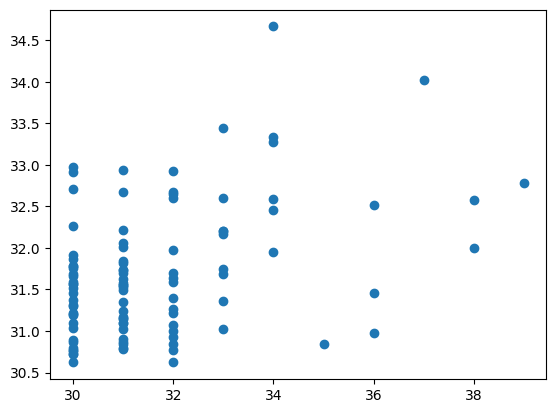

In [340]:
# Fit some curve to the data
from sklearn import linear_model
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(
    unpivot_df[['def_sacks', 'def_tackles', 'def_interceptions']].values,
    unpivot_df['max_age'].values,
    test_size=0.2,
    random_state=42)
reg = linear_model.LinearRegression()
model = reg.fit(train_x, train_y)
test_result = model.predict(test_x)
plt.scatter(test_y, test_result)

### Attempt a Regression

Just a cursory attempt at finding any kind of regression based on the available data (sacks, interceptions, and tackles) shows that this data just doesn't reveal any patterns. It would be best to treat all players the same.

Additional research into factors that lead to players retiring or being cut might yield more specific predictions for given players. Note: We may want to look at how we might see performance fall off over time.

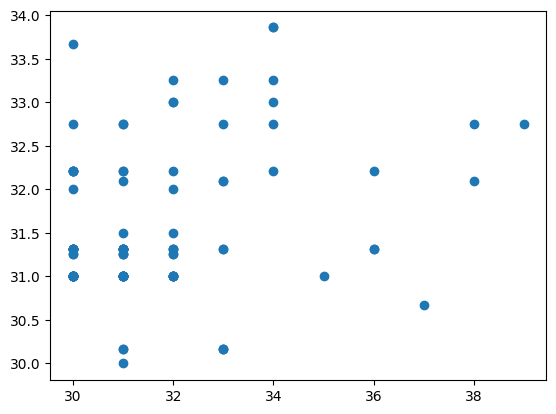

In [341]:
# Use scipy DecisionTreeRegressor to train and then test the test set
# plot the predictions vs actual values in the test set
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(max_depth=5)
dt_model = dt_reg.fit(train_x, train_y)
dt_test_result = dt_model.predict(test_x)
plt.scatter(test_y, dt_test_result)

In [342]:
older_than_30 = def_df[def_df['age'] > 30]

# Keep the last season for each player and subtract 30 from the age
older_than_30 = older_than_30.groupby("player_id").last()
older_than_30['age'] = older_than_30['age'] - 30
older_than_30['age']

player_id
00-0000017    1
00-0000065    4
00-0000097    3
00-0000100    4
00-0000136    4
             ..
00-0034203    1
00-0034382    1
00-0034760    1
00-0034887    1
00-0034902    1
Name: age, Length: 973, dtype: int64

/var/folders/4b/7v01nk757qsbhc05_11mrdnr0000gn/T/ipykernel_3358/2952973885.py:9: RuntimeWarning: Bounds provided for the following unrecognized parameters will be ignored: {'n'}
  res = stats.fit(dist, retired_players_over_30.to_list(), bounds= {'n': (0,.8)})


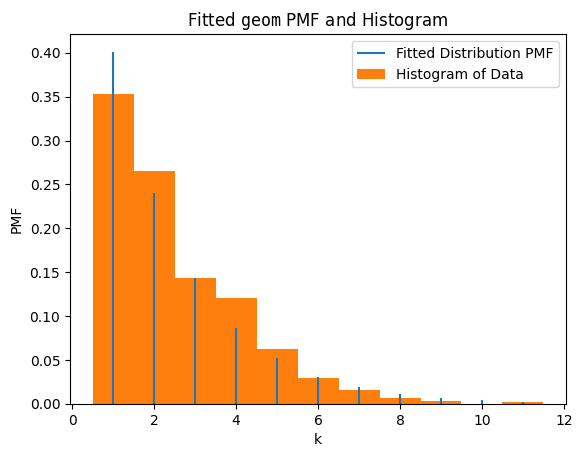

In [343]:
from scipy import stats

# Try fitting the data to a geometric distribution (seemed like the closest)
retired_des_over_30 = retired_df[
        ~((retired_df["status"] == "ACT") ) & (retired_df["age"] > 30) & (retired_df["position"].isin(["DE", "DT"]) )
    ].groupby('player_id').last()['age'] - 31

dist = stats.geom
res = stats.fit(dist, retired_players_over_30.to_list(), bounds= {'n': (0,.8)})
res.plot()
p, loc = res.params



In [344]:
# Does this data reasonably fit a geometric distribution?
from collections import Counter
predicted = Counter(stats.geom.rvs(p, size=retired_des_over_30.count())-1)
actual = Counter(retired_des_over_30.values)

# Try to calculate chi squared for goodness of fit
chi_diff = 0

# Sum of expected - actual^squared / actual
for i in range(0,10):
    chi_diff += ((predicted[i] - actual[i])**2) / (actual[i])
dof = len(predicted.values()) - 1
area_of_tail = stats.chi2.sf(chi_diff, dof)
if area_of_tail < 0.05:
    print("Reject Null Hypothesis: Data does not fit geometric distribution")

Reject Null Hypothesis: Data does not fit geometric distribution


The samples do not fit a geometric distribution. I used R instead to fit a polynomial line. See below.

### Now Predict the Longevity of Trey

See longevity.R for a simple R script that finds the lower and upper prediction percentages for a defensive player remaining in the NFL for 4 seasons.

It resulted in a prediction between 32% and 45%